In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from astropy import modeling
set_matplotlib_formats('retina')
from matplotlib import font_manager, rc
# font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
# rc('font', family=font_name)
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from inspect import signature
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

from scipy import stats
from torch.utils.data import  TensorDataset, DataLoader
from torchvision.utils import save_image
import os
from os import listdir
from os.path import isfile, join
# [f for f in listdir('./model') if isfile(join(mypath, f))]

import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, roc_curve

In [3]:
# data=pd.read_csv("./data_1004.csv")
data=pd.read_csv("./data1201.csv")
# data=pd.read_csv("./data2100205.csv")

columns = data.iloc[:,2:-19].columns
columns =columns.drop(['pleura_tb', 'pleura_bac','blood_positive', 'blood_obscure', 'cancer'])
float_column=data[columns].select_dtypes(include=['float']).columns
object_column = data[columns].select_dtypes(include=['object']).columns
not_object = ['D-dimer', 'BNP', 'procalcitonin', 'ANA titer','ANA 1:40','ionized calcium','E-ANC_blood']

data[not_object[0]] = data[not_object[0]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[1]] = data[not_object[1]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[2]] = data[not_object[2]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[5]] = data[not_object[5]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)

def floating(x):
    try:
        value = float(x)
    except ValueError :
        value = np.nan
    return value

data[not_object[6]] = data[not_object[6]].replace("\-","",regex=True).apply(floating).astype(float)
data[not_object[4]] = data[not_object[4]].replace({np.nan:0, 
  'Neg(<1:40)':0,
  'Non(<1:40)':0,
  'Pos. Speckled':1,
  'Reactive Speckled':2,
  'Cytoplasmic':3,
  'Reactive Nuclear membrane':4,
  'Positive Speckled':5})

data[not_object[3]] =  data[not_object[3]].replace({np.nan:0,
 '<1:40':0,
 'Speckled 1:1280':1,
 'Speckled 1:40':2,
 'Nucleolar 1:80':3,
 'Homogene.1:640':4,
 'Mixed type(Remark)':5,
 'Nucle.Membrane 1:80':6,
 'Speckled 1:160':7,
 'Homogene.1:40':8,
 'Nucleolar 1:640':9,
 'Homogene.1:160':10,
 'Discr.speckled 1:1280':11,
 'Nucleolar 1:40':12,
 'Homogene.1:80':13,
 'Homogene.1:1280':14,
 'Speckled 1:320':15})

data[['ANA1','ANA2','ANA3','ANA4','ANA5','ANA6','ANA7','ANA8','ANA9','ANA10','ANA11','ANA12','ANA13','ANA14',
    'ANA15','ANA16']]=pd.DataFrame(np.eye(len(data[not_object[3]].unique()))[data[not_object[3]]])

data[['ANA_1','ANA_2','ANA_3','ANA_4','ANA_5','ANA_6']]=pd.DataFrame(np.eye(len(data[not_object[4]].unique()))[data[not_object[4]]])

reallist = float_column.tolist()+['D-dimer', 'BNP', 'procalcitonin','ionized calcium','E-ANC_blood']
analist = ['ANA1','ANA2','ANA3','ANA4','ANA5','ANA6','ANA7','ANA8','ANA9','ANA10','ANA11','ANA12','ANA13','ANA14',
    'ANA15','ANA16','ANA_1','ANA_2','ANA_3','ANA_4','ANA_5','ANA_6']

count_label = pd.DataFrame(data.count()/len(data))

data.loc[data['ph_pleural fluid'].isna(), 'ph_pleural fluid'] = data.loc[data['ph_pleural fluid'].isna(), 'pH_pleural fluid(Qn) ']

list_04 = ['ADA_pleural fluid', 'LD_pleural fluid', 'albumin_pleural fluid', 'ph_pleural fluid', 'Total protein_pleural fluid', 'Glucose_pleural fluid',
'Total amylase_pleural fluid', 'Creatinine', 'AST(SGOT)', 'Alkaline phosphatase', 'total bilirubin', 'glucose', 'Albumin', 'BUN',
'Total protein', 'LD', 'ALT(SGPT)', 'r-GT', 'CRP', 'D-dimer', 'BNP', 'procalcitonin', 'total calcium', 'sodium', 'chloride', 'potassium', 'phosphorus', 'Hb_blood',
'RDW_blood', 'WBC_blood', 'MCHC_blood', 'MCV_blood', 'PDW_blood', 'Hct_blood', 'E-ANC_blood', 'MCH_blood', 'RBC_blood', 'MPV_blood', 'Platelet_blood', "Histiocyte (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Neutrophil (Qn)[Cytospin,Wright's stain],Pleural fluid", "RBC (Qn)[Cytospin,Wright's stain],Pleural fluid", "Eosinophil (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Nucleated cells (Qn)[Cytospin,Wright's stain],Pleural fluid", "Lymphocyte (Qn)[Cytospin,Wright's stain],Pleural fluid", "Mesothelial cell (Qn)[Cytospin,Wright's stain],Pleural fluid"
          ]

xlist =dict()

for i in range(len(list_04)):
    xlist.update({data[list_04[i]].name: stats.mode(data[list_04[i]]).mode.item()})

for i in range(len(list_04)):
    data[list_04[i]] = data[list_04[i]].replace(np.nan, xlist[list_04[i]])

data.loc[data['pleura_bac']>0,'Labeling']=3

data.loc[((data['Labeling'].isin([3,17,"3","17"]))& (data['제외']!=1)),'new_label']="bacterial"
data.loc[((data['Labeling'].isin([1,"1"]))& (data['제외']!=1)),'new_label']="tuberculosis"
data.loc[((data['Labeling'].isin([2,"2"]))& (data['제외']!=1)),'new_label']="malignancy"
data.loc[((data['Labeling'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'new_label']="volume"
data.loc[((data['Labeling'].isin([7,10,14,19,25,29,30,"7","10","14","19","25","29","30"]))
          & (data['제외']!=1)),'new_label']="other"
data.loc[((data['Labeling'].isin([8,16,24,23,20,21,27,28,"8","16","24","23","20","21","27","28"]))
          & (data['제외']!=1)),'new_label']="other"
data.loc[((data['Labeling'].isin([9,15,"9","15"]))& (data['제외']!=1))
         ,'new_label']="other"

data.loc[((data['Labeling'].isin([3,17,"3","17"]))& (data['제외']!=1)),'new_int']=0
data.loc[((data['Labeling'].isin([1,"1"]))& (data['제외']!=1)),'new_int']=1
data.loc[((data['Labeling'].isin([2,"2"]))& (data['제외']!=1)),'new_int']=2
data.loc[((data['Labeling'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'new_int']=3
data.loc[((data['Labeling'].isin([7,10,14,19,25,29,30,"7","10","14","19","25","29","30"]))
          & (data['제외']!=1)),'new_int']=4
data.loc[((data['Labeling'].isin([8,16,24,23,20,21,27,28,"8","16","24","23","20","21","27","28"]))
          & (data['제외']!=1)),'new_int']=4
data.loc[((data['Labeling'].isin([9,15,"9","15"]))& (data['제외']!=1))
         ,'new_int']=4
data.loc[((data['new_int'].isna())& (data['제외']!=1))
         ,'new_int']=4

data = data.loc[data['제외']!=1]

training = data[list_04+['new_label']+['new_int']]
training_only = training.loc[training['new_label'].isna()==False]
col_name  = training.columns.difference(["new_label",'new_int'])

# training[col_name]

range_lower = 0.05
range_upper = 0.95
outcome_quantile = training[col_name].quantile([range_lower, range_upper])

for i in col_name:
    training.loc[(training[i]<=outcome_quantile[i][range_lower]),i]=\
        outcome_quantile[i][range_lower]

    training.loc[(training[i]>=outcome_quantile[i][range_upper]),i]=\
        outcome_quantile[i][range_upper]

label_name = data.loc[(data['new_label'].isna()==False)&
                      (data['new_label']!=7), 'new_label'].unique()


scaler01 = MinMaxScaler(feature_range=(0.01,1))
scaler01 = scaler01.fit(training[col_name])
training[col_name] = scaler01.transform(training[col_name])

In [4]:
#label붙은것만 뽑기
training = training.loc[training['new_label'].isna()==False]



In [5]:
# Device configuration
X_train, X_notrain, y_train, y_nottrain = train_test_split(training[col_name],
                                                    training['new_int'], test_size = 0.3
                                                    , random_state = 52
                                                   )

X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train = torch.tensor(y_train.values.astype(int), dtype=torch.float32)
X_notrain = torch.tensor(np.array(X_notrain), dtype=torch.float32)
y_nottrain = torch.tensor(y_nottrain.values.astype(int), dtype=torch.float32)

train_data = TensorDataset(X_train, y_train)
total_val_data = TensorDataset(X_notrain, y_nottrain)


### tensorboard example

In [6]:
from torch.utils.tensorboard import SummaryWriter

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [7]:
history = []
n_epochs_stop = 20
PATH = './simple_model_0502/'
epoch = 50000
min_epoch =100
small_layer_list = [[128,256,128,32,20],
         [256,512,128,64,20],
          [256,256,256,256,20],
         [512,512,512,512,20],
         [1024,1024,1024,20]]

device = 'cuda:0'
CEloss = nn.CrossEntropyLoss()


In [8]:
from torch.utils.data import WeightedRandomSampler
batch_size, val_batch_size = 450,223

#weighted sampler 
# test-set의 proportion
weight = 1/np.array([201, 123, 600, 100, 200])

samples_weight = np.array([weight[t] for t in y_train.numpy().astype(int)])
samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
train_sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

val_samples_weight = np.array([weight[t] for t in y_nottrain.numpy().astype(int)])
val_samples_weight = torch.from_numpy(val_samples_weight)
val_samples_weight = val_samples_weight.double()
val_sampler = WeightedRandomSampler(val_samples_weight, len(val_samples_weight))

train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           sampler = train_sampler)

val_loader = torch.utils.data.DataLoader(dataset=total_val_data, 
                                           batch_size=val_batch_size, 
                                           sampler = val_sampler)


In [9]:
class small_model(nn.Module):
    def __init__(self, x_len, class_param, class_len):
        super(small_model, self).__init__()
              
        self.classifier_layers = nn.ModuleList()

        for i, param in enumerate(class_param):
            if i==0:
                self.classifier_layers.append(nn.Linear(x_len, param))
                self.classifier_layers.append(nn.Dropout(0.3))
                pre_param = param
            elif i==len(class_param)-1:
                self.classifier_layers.append(nn.Linear(pre_param, param))
                self.classifier_layers.append(nn.Dropout(0.3))
                self.classifier_layers.append(nn.Linear(param, class_len))        
            else:
                self.classifier_layers.append(nn.Linear(pre_param, param))
                self.classifier_layers.append(nn.Dropout(0.3))
                pre_param = param
                

    def classifier(self, train_x):
        
        for i, layer in enumerate(self.classifier_layers):
            if i!=len(self.classifier_layers)-1:
                if isinstance(layer, nn.Linear):
                    train_x = nn.ReLU()(layer(train_x))

                else:
                    train_x = layer(train_x)
            else:
                last = layer(train_x)
                
        pre_last = train_x
        last = last
        return pre_last, last
    
    def forward(self, z):
        # Encoder 를 통과

        pre_last, last = self.classifier(z)
        
        return pre_last, last

In [98]:
for layer in small_layer_list:
    model = small_model(x_len=46, class_param=layer, class_len=5)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), weight_decay = 1e-5, lr=0.00002)
    min_val_loss = np.Inf
    epochs_no_improve = 20
#         print("first",torch.cuda.memory_allocated())
    for num_epoch in range(epoch):
        average_loss = 0
        #training
        model = model.train()

        for batch_idx, (train_X,train_Y) in enumerate(train_loader):
            optimizer.zero_grad()
            train_X = train_X.to(device)
            train_Y = torch.tensor(train_Y, dtype= torch.long).to(device)

            pre_last, last = model(train_X)
#                 print("second",torch.cuda.memory_allocated())
            loss = CEloss(last, train_Y)
            loss.backward()
#                 print("third",torch.cuda.memory_allocated())
            optimizer.step()

            average_loss += loss.item()

#             print("after train end: ",torch.cuda.memory_allocated())

        average_loss /=len(train_loader)

        #validation set 
        aver_val_loss = 0
        model = model.eval()

        for val_X,val_Y in val_loader:
            val_X = val_X.to(device)
            val_Y = torch.tensor(val_Y, dtype= torch.long).to(device)

            val_prelast, val_last = model(val_X)
            loss_val = CEloss(val_last, val_Y)

            aver_val_loss += loss_val.item()
        aver_val_loss /=len(val_loader)

        if aver_val_loss <= min_val_loss:
            directory = PATH
            #directory 이름은 layer 첫번째 및 두번째 그리고 마지막 layer수 
            if not os.path.exists(directory):
                os.makedirs(directory)
            filename = [f for f in os.listdir(directory) if f.startswith("model_{}".format(layer))]
            if filename:
                if os.path.isfile(directory+filename[0]):
                    os.remove(directory+filename[0])
            torch.save(model, directory+'model_{}_{:.0f}.pt'.format(layer,aver_val_loss*1000))
            epochs_no_improve = 0
            min_val_loss = aver_val_loss
        else:
            epochs_no_improve += 1

        if (num_epoch+1) % 200 == 0:
            print('[{}-{}-{}] {}/{} epoch\tLoss = {: .6f} \t val_loss = {:.6f}\t min_val_loss ={:.6f}'\
                  .format(layer[0], layer[1], len(layer), num_epoch+1, epoch,  average_loss, aver_val_loss, min_val_loss))

        # If the validation loss is at a minimum
        if num_epoch > min_epoch and epochs_no_improve > n_epochs_stop:
            print('Early stopping! epoch:{}, min_val_loss:{:.5f}'.format(num_epoch, min_val_loss) )
            early_stop = True
            break
        else:
            continue

    history.append({
    'layer': layer,
    'average_loss': average_loss,
    'aver_val_loss': aver_val_loss})   

[128-256-5] 200/50000 epoch	Loss =  1.596346 	 val_loss = 1.569883	 min_val_loss =1.569883
Early stopping! epoch:299, min_val_loss:1.48679
[256-512-5] 200/50000 epoch	Loss =  1.421987 	 val_loss = 1.423862	 min_val_loss =1.415696
[256-512-5] 400/50000 epoch	Loss =  1.090578 	 val_loss = 1.018868	 min_val_loss =0.956142
Early stopping! epoch:429, min_val_loss:0.91668
[256-256-5] 200/50000 epoch	Loss =  1.337153 	 val_loss = 1.321923	 min_val_loss =1.321923
Early stopping! epoch:365, min_val_loss:0.90899
[512-512-5] 200/50000 epoch	Loss =  1.194674 	 val_loss = 1.087678	 min_val_loss =1.081026
Early stopping! epoch:364, min_val_loss:0.66373
[1024-1024-4] 200/50000 epoch	Loss =  0.755856 	 val_loss = 0.723837	 min_val_loss =0.670421
Early stopping! epoch:218, min_val_loss:0.67042


### 작은 model validation

In [99]:
os.listdir("./simple_model_0502/")

['model_[256, 512, 128, 64, 20]_917.pt',
 'model_[128, 256, 128, 32, 20]_1487.pt',
 'model_[256, 256, 256, 256, 20]_909.pt',
 'model_[512, 512, 512, 512, 20]_664.pt',
 'model_[1024, 1024, 1024, 20]_670.pt']

In [100]:
model = torch.load('./simple_model_0502/model_[1024, 1024, 1024, 20]_670.pt')
model = model.eval()
pre_last, p_label = model(X_notrain.to(device))
predict = torch.argmax(p_label, axis=1)

In [108]:
X_train

tensor([[0.0951, 0.1166, 0.2114,  ..., 0.6954, 0.0807, 0.5950],
        [0.2409, 0.4060, 0.6980,  ..., 0.9238, 1.0000, 0.0100],
        [0.0639, 0.0709, 0.0939,  ..., 0.7715, 0.1514, 0.5500],
        ...,
        [0.0420, 0.4974, 1.0000,  ..., 0.4669, 1.0000, 0.0100],
        [0.0951, 0.1014, 0.0771,  ..., 0.7715, 0.2929, 0.5500],
        [0.0951, 0.3298, 0.2449,  ..., 0.8477, 0.1514, 0.7750]])

In [101]:
# confusion_matrix(y_train, predict.cpu()),
print(confusion_matrix(y_nottrain, predict.cpu()))

#accuracy
print(accuracy_score(y_nottrain, predict.cpu()))
#classification report
print(classification_report(y_nottrain, predict.cpu()))

[[ 49   7   7   5   0]
 [  2  27   4   2   0]
 [ 15  10 217   8   0]
 [  0   0   4  28   0]
 [  5   5   6   3   0]]
0.7945544554455446
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.71        68
         1.0       0.55      0.77      0.64        35
         2.0       0.91      0.87      0.89       250
         3.0       0.61      0.88      0.72        32
         4.0       0.00      0.00      0.00        19

    accuracy                           0.79       404
   macro avg       0.55      0.65      0.59       404
weighted avg       0.78      0.79      0.78       404



In [102]:
from util import accuracy
acc1,acc2= accuracy(p_label.cpu(), y_nottrain, topk=(1, 2))
print("top1 accuracy:", acc1.item())
print("top2 accuracy:", acc2.item())

top1 accuracy: 79.4554443359375
top2 accuracy: 90.09900665283203


In [103]:
Y_val = torch.tensor(y_nottrain, dtype=torch.long)

one_hot_y = nn.functional.one_hot(Y_val)

soft = nn.Softmax(dim=1)
soft(p_label)
soft_x_predict = soft(p_label).cpu().detach().numpy()

print("weighted, ovr", roc_auc_score(one_hot_y, soft(p_label).cpu().detach().numpy(),  multi_class= 'ovr', average = 'weighted'))
print("macro, ovr ", roc_auc_score(one_hot_y, soft(p_label).cpu().detach().numpy(),  multi_class= 'ovr', average = 'macro'))
print("micro, ovr" , roc_auc_score(one_hot_y, soft(p_label).cpu().detach().numpy(),  multi_class= 'ovr', average = 'micro'))

weighted, ovr 0.9203032630100709
macro, ovr  0.885386684192347
micro, ovr 0.9441476325850406


In [18]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(one_hot_y.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(one_hot_y[:,i], soft_x_predict[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])



In [19]:
label_name = ['bacterial', 'tuberculosis','malignancy', 'volume', 'other']

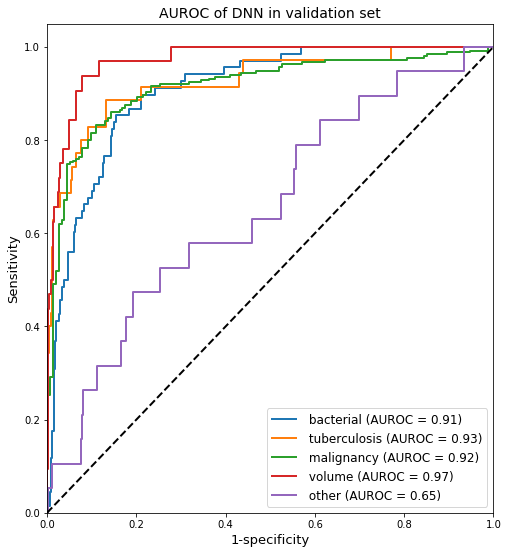

In [21]:
from itertools import cycle
import matplotlib.pyplot as plt
lw = 2

fig, ax = plt.subplots(figsize=(8,9))
for i in range(one_hot_y.shape[1]):
    ax.plot(fpr[i], tpr[i],
        #      color=color,
             lw=lw,
             label=' {0} (AUROC = {1:0.2f})'
             ''.format(label_name[i], roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('1-specificity', fontsize= 13)
ax.set_ylabel('Sensitivity', fontsize= 13)
ax.set_title('AUROC of DNN in validation set', fontsize= 14)
ax.legend(loc="lower right", fontsize=12)
plt.show()
fig.savefig("./figures/val_DNN four 300.png", dpi=300)